# Iron Ore Dataset

In this notebook we are going to use the dataset **Iron Ore** explored in week **05-simple-predictions** to illustrate a simple Deep Artificial Neural Network and discuss some of its disatvantages. 
     
As this dataset is not for classification, we borrow from week **05-simple-predictions** the code below to transform the problem into a classification problem:

```python
# Splits from oscar Fe>60%, SiO2<9, Al2O3<2, P<0.08
split_points = [
    ('FE', 60, [False, True]),
    ('SIO2', 9, [True, False]),
    ('AL2O3', 2, [True, False]),
    ('P', 0.08, [True, False]),  
]

# It's ore if everything is True
df['is_ore'] = np.vstack([
    pandas.cut(df[elem], bins=[0, split, 100], labels=is_ore)
    for elem, split, 
```

In order to have a clean notebook, some functions are implemented in the file *utils.py* (e.g., plot_decision_boundary). We are not going to discuss the implementation aspects of these functions as it is not the scope, but you can to explore and read the content of the functions later on.

Summary:
 - [Data Pre-processing](#preprocessing)
 - [Building the DNN](#dnn)
     - [Training the Model](#train)
     - [Prediction and Performance Analysis](#performance)
     
__All the libraries used in this notebook are <font color='red'>Open Source</font>__.

## Data Pre-processing
<a id=preprocessing></ad>

In [1]:
# Standard libraries
import numpy as np  # written in C, is faster and robust library for numerical and matrix operations
import pandas as pd # data manipulation library, it is widely used for data analysis and relies on numpy library.
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # Plot nicely =) . Importing seaborn modifies the default matplotlib color schemes and plot 
                      # styles to improve readability and aesthetics.

# Auxiliar functions
from utils import *

from sklearn.model_selection import train_test_split #split arrays or matrices into random train and test subsets
from sklearn.preprocessing import StandardScaler #Standardize features by removing the mean and scaling to unit variance

# the following to lines will tell to the python kernel to always update the kernel for every utils.py
# modification, without the need of restarting the kernel.
%load_ext autoreload
%autoreload 2

# using the 'inline' backend, your matplotlib graphs will be included in your notebook, next to the code
%matplotlib inline

Using TensorFlow backend.


We are going to use [Pandas](https://pandas.pydata.org/) for the data processing. The function  [read_csv](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) is going to be used to read the csv file.

In [2]:
# reading dataset
df = pd.read_csv('../data/iron_ore_study.csv')

# Splits from oscar Fe>60%, SiO2<9, Al2O3<2, P<0.08
split_points = [
    ('FE', 60, [False, True]),
    ('SIO2', 9, [True, False]),
    ('AL2O3', 2, [True, False]),
    ('P', 0.08, [True, False]),  
]

# It's ore if everything is True
df['is_ore'] = np.vstack([
    pd.cut(df[elem], bins=[0, split, 100], labels=is_ore)
    for elem, split, is_ore in split_points
]).sum(axis=0) == 4

y = df.is_ore # set the variable 'y' to store the labels
# removing is_ore from the dataframe 
list = ['is_ore']
df = df.drop(list,axis = 1 )

# split data train 70% and test 30%. You can try other splits here.
x_train, x_test, y_train, y_test = train_test_split(df, y, test_size=0.3, 
                                                    random_state=42)

y_train = y_train.values # converting to numpy array
y_test = y_test.values # converting to numpy array

# normalising the data
scaler = StandardScaler()
scaler.fit(x_train) # not considering the label is_ore
x_train_scaled = scaler.transform(x_train)

x_test_scaled = scaler.transform(x_test)

Here we transform this dataset into a classification task using the strategy adopted in week **05-simple-predictions**.

In [3]:
print(type(x_train_scaled), type(x_test_scaled))
print(x_train_scaled.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(2450, 4)


## Building the Deep Neural Network
<a id=dnn></a>

We are going to use [Keras](https://keras.io/) to build our first Deep Neural Network. It is a high-level API for deep learning, which is a wrapper of TensorFlow, CNTK, or Theano. Keras was developed with a focus on enabling fast experimentation, which makes this framework easy to use and learn deep learning.

To build the model, we will use the following components from Keras:

 - [Sequencial](https://keras.io/models/sequential/): allows us to create models layer-by-layer. 
 - [Dense](https://keras.io/layers/core/#dense): provides a regular fully-connected layer
 - [Dropout](https://keras.io/layers/core/#dropout): provides dropout regularisation

Basically, we are going to define the sequence of our model by using _Sequential()_, which include the layers:

```python
    model = Sequential()
    model.add(Dense(...))
    ...
```
once created the model we can configure the model for training using the method [compile](https://keras.io/models/model/). Here we need to define the [loss](https://keras.io/losses/) function (mean squared error, mean absolute error, cosine proximity, categorical cross entropy, among others.), the [optimizer](https://keras.io/optimizers/) (Stochastic gradient descent, RMSprop, adam, among others) and the [metric](https://keras.io/metrics/) to define the evaluation metric to be used to evaluate the performance of the model in the training step, as follows:

```python
    model.compile(loss = "...", 
                  optimizer = "...")
```

Also, we have the option to see a summary representation of the model by using the function [summary](https://keras.io/models/about-keras-models/#about-keras-models). This function summarises the model and tell us the number of parameters that we need to tune.

In [4]:
from keras.models import Sequential # implements sequential function
from keras.layers import Dense # implements the fully connected layer
from keras.layers import Dropout # implements Dropout regularisation

In [5]:
# Define the model.
model = Sequential()

# Dense layer (fully connected)
# First layer:
#  we need to define the input shape, which is the same of the shape of the training set
#  which is 4
#  128 neurons
#  relu for activation function
model.add(Dense(128, input_shape=(x_train_scaled.shape[1],), activation='relu', name='first_layer'))

# Regularisation:
#  Dropout consists in randomly setting a fraction rate of input units to 
#  0 at each update during training time, which helps prevent overfitting.
#  for this model, we are going to define a rate equal 60% (0.6)
model.add(Dropout(0.6))

# second layer: output, 
#  one neuron (binary output)
#  sigmoid for activation function
model.add(Dense(1, activation='sigmoid', name='output_layer'))

# Compile:
#  Optimiser: adam
#  Loss: binary_crossentropy, as our problem is binary classification (is_ore or not is_ore)
#  Metric: binary_accuracy
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

In [6]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first_layer (Dense)          (None, 128)               640       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
output_layer (Dense)         (None, 1)                 129       
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


We have 769 parameters to be tuned. The first layer (first_layer) has 640 parameters, given by:

$$\#first\_layer =  input\_shape * W_1 + b_1$$
where input_shape is given by the features (FE, SIO2, AL203 and P), $W_1$ are the weights in the first layer and $b_1$ is the bias shape, so we have:

$$\#first\_layer =  4 * 128 + 128 = 640$$

The second layer (output_layer) has 129 paramers, given by: 

$$\#output\_layer =  \#W_1 * W_2 + b_2$$
where $\#W_1$ is the shape of the *first_layer*, $W_2$ are the weights in the second layer and $b_2$ is the bias shape, so we have:

$$\#output\_layer =  128 * 1 + 1 = 129$$

### Training the Model
<a id=train></a>

Once defined the model, we need to train it by using the function [fit](https://keras.io/models/model/). This function performs the optmisation step. Hence, we can define the following parameters such as:

 - batch size: defines the number of samples that will be propagated through the network.
 - epochs: defines the number of times in which all the training set (x_train_scaled) are used once to update the weights.
 - validation split: defines the percentage of training data to be used for validation
 - among others (click [here](https://keras.io/models/model/) for more information)
 
This function return the _history_ of the training, that can be used for further performance analysis.

In [7]:
# training the model
batch_size = 128 
n_epochs = 150
history = model.fit(x_train_scaled,  #training set
                    y_train, # labels
                    batch_size = batch_size,
                    epochs = n_epochs,
                    validation_split = 0.2, # 20% percent for validation and 80% for training
                    verbose = 0 # muting the output, you can set this to 1 (default) to get insights 
                                # about the loss and accuracy for every epoch
                   )


### Prediction and Performance Analysis
<a id='performance'></a>

Here we can see if the model overfits or underfits. First, we are going to plot the 'loss' and the 'Accuracy' from the training step.

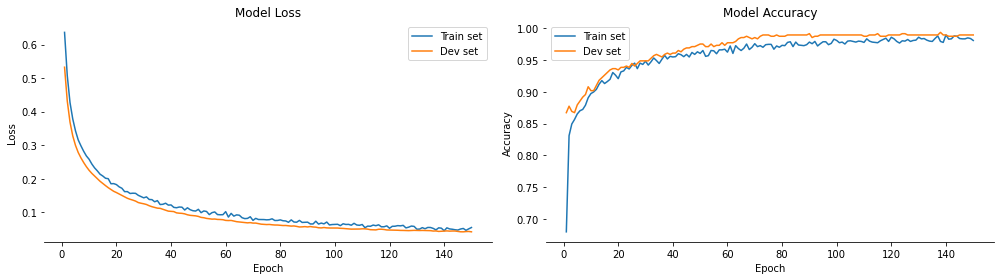

In [8]:
plot_loss_and_accuracy(history=history)

**Question**: Does the model overfits?

Once the model was trained, we can use function [predict_classes](https://keras.io/models/model/) to do some predictions and evaluate the performance of the model. As we saw in the last week, the performance assessment of the classifiers is **extremely important** in practice, as this provide insights of how the classifier performs on new data, which measures the **generalisation error**.

In [9]:
predictions = model.predict_classes(x_test_scaled, batch_size=batch_size) # predict the classes
pred = predictions.ravel() # Return a contiguous flattened array, in this case a 1-D array, containing the elements of the 
                           # predictions.
pred = pred.astype(dtype=np.bool) # if nedeed, we can define the type of the array as boolean.

In [10]:
# we are going to use F-measure to evaluate the performance
from sklearn.metrics import f1_score # computes the f1 score

# we are using prediction computed previsously
f1_score_knn = f1_score(y_test, pred)
print('F1-score: ', f1_score_knn)

F1-score:  0.9985029940119761


Another way to evaluate the model is by using the function [evaluate](https://keras.io/models/model/) provided by keras. This return the loss value & metrics values for the model in test mode. The metrics used is the same define in the **fit** function, in which this case is "binary_accuracy".

In [11]:
loss_value, acc_value = model.evaluate(x_test_scaled, y_test, verbose=0)
print('Loss value: ', loss_value)
print('Binary acurracy value: ', acc_value)

Loss value:  0.036991866819915314
Binary acurracy value:  0.9980952143669128


**Your turn**

1) Evaluate the performance of the model by changing the "activation function". Here you can try "sigmoid" or "tanh".

For example:
```python
model.add(Dense(128, input_shape=(x_train_scaled.shape[1],), activation='sigmoid', name='first_layer'))
```

You will need to create a new model, compile it and fit it.

2) Evaluate the performance of the model by changing the number of neurons in the first layer. 

For example:
```python
model.add(Dense(64, input_shape=(x_train_scaled.shape[1],), activation='...', name='first_layer'))
```

You will need to create a new model, compile it and fit it.

3) Create a new DNN model, a deepest one (more layers) and evaluate its performance. 

    3.1) Create the model

For example:
```python
# Define the model.
dnn = Sequential()

# layer 1
dnn.add(Dense(128, input_shape=(x_train_scaled.shape[1],), activation='relu', name='first_layer'))
dnn.add(Dropout(0.6))

# layer 2
dnn.add(Dense(256, activation='relu', name='second_layer'))
dnn.add(Dropout(0.6))

# layer 3
dnn.add(Dense(128, activation='relu', name='third_layer'))
dnn.add(Dropout(0.6))

# output layer
dnn.add(Dense(1, activation='sigmoid', name='output_layer'))
```


  3.2) Try other optimisers ('rmsprop', 'sgd', 'adagrad' or 'adadelta' if you wich), loss and metrics
  
For example:  
```python    
dnn.compile(optimizer='adam', 
            loss='binary_crossentropy',
            metrics=['binary_accuracy'])
```


  3.3) Summarize the model by using.
```python
dnn.summary()
```



  3.4) Train the model, here you can define the number of epochs and batch_size that best fit for you model

For example:  
```python 
batch_size = 32 
n_epochs = 20
history = dnn.fit(x_train_scaled,  
                    y_train, 
                    batch_size = batch_size,
                    epochs = n_epochs,
                    validation_split = 0.1, # 10% percent for validation and 80% for training
                    verbose = 0
                   )
```


  3.5) Evaluate the model performance by using the metric that you think is the best.

For example:  
```python 
loss_value, acc_value = dnn.evaluate(x_test_scaled, y_test, verbose=0)
print('Loss value: ', loss_value)
print('Binary acurracy value: ', loss_value)
```

Plot the loss and accuracy if you which.